In [1]:
import matplotlib as m
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, sobel
from scipy.optimize import curve_fit
from scipy import signal
from skimage import io
import os
from skimage import data
import imageio

# Import

In [2]:
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP') #import metadata
os.chdir(r'Data\25.02\OneDrive_2_25-02-2022\Bilayer3_post bleach7_1')
meta_data_filename= 'Bilayer3_post bleach7_1_MMStack_Default_metadata.txt'
md = pd.read_json(meta_data_filename) 



os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP')
os.chdir(r'Data\Control\drive-download-20220317T085515Z-001\well9_561nm_OD2_POPC(c)_1')
filename_bg = 'well9_561nm_OD2_POPC(c)_1_MMStack_Pos0.ome.tif'
bg = io.imread(filename_bg)

os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP')
os.chdir(r'Data\Control\drive-download-20220317T085515Z-001\well10_561nm_OD2_POPC(c)_1')
filename_bg2 = 'well10_561nm_OD2_POPC(c)_1_MMStack_Pos0.ome.tif'

bg2 = io.imread(filename_bg2)

background = np.mean(np.concatenate((bg,bg2))) # find the average background counts
background= background.astype(float)


#Import pre and post bleach
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP')
os.chdir(r'Data\25.02\OneDrive_2_25-02-2022')
filename_post = 'Bilayer3_post bleach7_1\Bilayer3_post bleach7_1_MMStack_Default.ome.tif'
filename_pre = 'Bilayer3_pre bleach7_1\Bilayer3_pre bleach7_1_MMStack_Default.ome.tif'

im_post = io.imread(filename_post)
im_pre = io.imread(filename_pre)
im_post = im_post.astype(float) #Convert the entries in each array to floats
im_pre = im_pre.astype(float) #Convert the entries in each array to floats

im_post = im_post-background #Correct for bg counts
im_pre = im_pre-background #Correct for bg counts

print(np.shape(im_post))
print(np.shape(im_pre))

(3000, 512, 512)
(100, 512, 512)


# Take the pre from the post to find the bleached spot

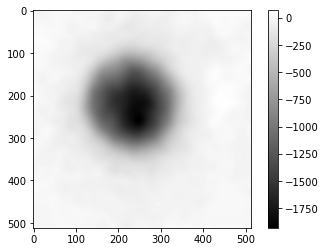

In [3]:
spot = im_post[0]-im_pre[-1] #take the last image from pre from the first image post- only left with the spot (negative values)
spot= gaussian_filter(spot,sigma=10) #gaussian blur
fig, ax= plt.subplots()
plot= ax.imshow(spot,cmap=plt.cm.gray)
fig.colorbar(plot)
plt.show()

# Set a limit and find the spot

In [4]:
limit = np.mean(spot)*2  #set a thershold of all values a 2 over the mean value (this will be negative)
spot_df= pd.DataFrame(data=np.empty((512, 1)),columns={'Col'},dtype=object)
for i in range(512):
        spot_index = [idx for idx, val in enumerate(spot[i,:]) if val < limit] #Get index of values that are below the limit
        spot_df.loc[i,'Col'] = spot_index
print(spot_df)
spot_df=spot_df[spot_df['Col'].map(lambda d: len(d)) > 0] #Remove empty lists
print(spot_df)

    Col
0    []
1    []
2    []
3    []
4    []
..   ..
507  []
508  []
509  []
510  []
511  []

[512 rows x 1 columns]
                                                   Col
100      [222, 223, 224, 225, 226, 227, 228, 229, 230]
101  [216, 217, 218, 219, 220, 221, 222, 223, 224, ...
102  [212, 213, 214, 215, 216, 217, 218, 219, 220, ...
103  [209, 210, 211, 212, 213, 214, 215, 216, 217, ...
104  [207, 208, 209, 210, 211, 212, 213, 214, 215, ...
..                                                 ...
335  [219, 220, 221, 222, 223, 224, 225, 226, 227, ...
336  [222, 223, 224, 225, 226, 227, 228, 229, 230, ...
337  [226, 227, 228, 229, 230, 231, 232, 233, 234, ...
338  [229, 230, 231, 232, 233, 234, 235, 236, 237, ...
339  [233, 234, 235, 236, 237, 238, 239, 240, 241, ...

[240 rows x 1 columns]


220
232


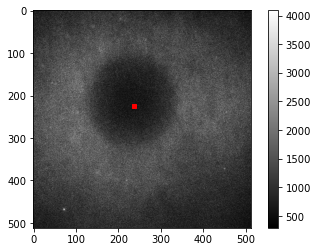

In [5]:
fig, ax= plt.subplots()
center_y =spot_df.index[round((len(spot_df)/2))]
print(center_y)
center_x = spot_df['Col'][center_y][round(len(spot_df['Col'][center_y])/2)]
print(center_x)
rect = plt.Rectangle((center_x, center_y), 10, 10,color='r')
plot= ax.imshow(im_post[0],cmap=plt.cm.gray)
fig.colorbar(plot)
ax.add_patch(rect)
plt.show()

# Correct for uneven illumination

Take the mean of the pre bleach images

In [4]:
mean_pre = np.empty((512,512))  #create an empty array for the averaged pre image
for j in range(len(im_pre[1])): #Iterate over all rows
    for i in range(len(im_pre[2])): #Iterate over all columns
        mean_pre[i][j] = np.mean(im_pre[:,i,j]) #Calculate the average of each pixel and set the value of the mean array

Divide all the images post and pre bleach by the pre bleach average (normalise the data to the pre-bleach images)

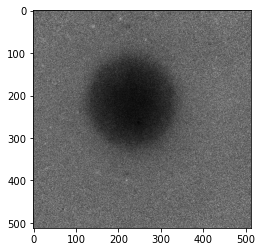

In [5]:
for i in range(len(im_post[:,0,0])): # Divide all images after bleach by the pre bleach average
    im_post[i]= im_post[i]/mean_pre
    
    
    
for i in range(len(im_pre[:,0,0])): # Divide all images pre bleach by the pre bleach average
    im_pre[i]= im_pre[i]/mean_pre
    
fig, ax= plt.subplots()
ax.imshow(im_post[0],cmap=plt.cm.gray)
plt.show()

# Find temporal fluctuations function from reference area

In [6]:
limit = np.mean(spot) #set a thershold of all values a over the mean value, spot= (first postbleach-last pre bleach)
## Only find the reference area once
reference_df= pd.DataFrame(data=np.empty((512, 2)),columns={'Col', 'Ave_Col'},dtype=object) # Create an empty df
for i in range(512):
        reference_index = [idx for idx, val in enumerate(spot[i,:]) if val > limit] #Get index of values that are above the limit(mean)
        reference_df.loc[i,'Col'] = reference_index
reference_df=reference_df[reference_df['Col'].map(lambda d: len(d)) > 0] #Remove empty lists- should'nt be any in this case

temporal_array= np.empty((1,len(im_post))) #Create an array to put the temporal change data in

for j in range(len(im_post)):
    ## Calculate the average intensity at each 
    ref_array= np.empty((1,512))
    for i in range(len(reference_df['Col'])): #Iterate over all the rows
        ref_array[:,i]= np.mean(im_post[j][reference_df.index[i]]) #Calculate the mean at each row for each column
    ave_ref_int =  np.mean(ref_array)# calculate the mean at each column (all the reference pixels)
    temporal_array[:,j]= ave_ref_int
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


# Fit an exponential decay to the temporal fluctuations

In [7]:
x=np.array([i for i in range(len(im_post))])
def func(x,a,b):
    return (a*(np.exp(-x/b)))
popt, pcov = curve_fit(func, x, temporal_array[0,:], maxfev=100000000)#, p0=[13000,4000000,-1300])#, method='lm')
print(popt)
print(pcov)
perr_sd = np.sqrt(np.diag(pcov))
print(perr_sd)

[8.98229869e-01 2.97726008e+04]
[[ 5.81806784e-08 -2.92091708e-02]
 [-2.92091708e-02  1.98907508e+04]]
[2.41206713e-04 1.41034573e+02]


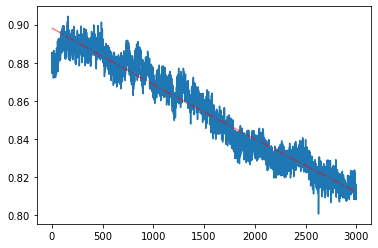

In [8]:
a, b = popt
fig, ax= plt.subplots()
ax.plot(x,temporal_array[0,:])
ax.plot(x, func(x,*popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')

# Correct data for temporal variations

In [9]:
for i in range(len(im_post[:,0,0])): # Divide all images after bleach by function which gives the amount photofaded
    im_post[i]= im_post[i]/func(i,a,b)

# Fit a 2D gaussian to the images

In [13]:
def expguass(VARS,x0,y0,depth,Re):
    X,Y= VARS
    return np.exp(-depth*np.exp((-2*((X-x0)**2+(Y-y0)**2))/(Re**2))) #Define the expnonential gaussain


df= pd.DataFrame(columns=['x0', 'y0', 'Depth', 'Re','Intensity at Re=sd','Time (s)'],index=np.arange(100)) #Create a df to put the fittted parameters in

x,y = np.arange(0, 512), np.arange(0, 512) #Define the x and y grid for fitting- as a 2D function need to use meshgrid and later ravel
X, Y = np.meshgrid(x, y)

#cen_x = spot_df.index[round(len(spot_df.loc[106]['Col'])/2)]#  find the middle column of the middle row- just for initial guess with fitting
#cen_y = spot_df.index[round((len(spot_df))/2)] #find the middle of the rows- just for initial fitting guess

xdata = np.vstack((X.ravel(), Y.ravel())) # Define xdata for fitting (really x and y data)
for i in range(100): # Perform fitting over however many images you need
    Z= im_post[i] #Define the Z data as your image data
    
    popt,pcov = curve_fit(expguass,xdata,Z.ravel(),p0=[256,256,1,1],maxfev = 100000) #Perform fit 
    x0,y0,depth,Re= popt
    
    perr_sd = np.sqrt(np.diag(pcov)) #Calculate the error on the fit
    df.iloc[i] = {'x0': x0, 'y0': y0,'Depth':depth,'Re':Re} #Place the values in the df
    #print(i)
    
    

Find the intensity when Re=r

In [23]:
df['Intensity at Re=sd'] = np.exp(-(df['Depth'].astype(float))*(np.exp(-2)))

Get the times at each frame- only doing 100 frames here as we are restricting ourselves to this for now

In [24]:
df['Time (s)']= (((md.loc['ElapsedTime-ms'][1:]- md.loc['ElapsedTime-ms'][1])/1000).to_numpy())[0:100]

In [25]:
df

,x0,y0,Depth,Re,Intensity at Re=sd,Time (s)
0,232.95786,218.336303,1.801532,106.070182,0.783636,0.0
1,233.092048,218.071128,1.809324,106.420801,0.782810,0.03291
2,232.934556,218.569744,1.803335,107.280163,0.783445,0.06582
3,232.925181,218.085115,1.787691,106.259405,0.785105,0.09873
4,233.11403,218.204837,1.777454,105.90348,0.786194,0.13165
...,...,...,...,...,...,...
95,232.69305,216.161851,1.391977,107.247798,0.828297,3.14562
96,232.473162,216.364436,1.398998,107.991755,0.827510,3.17903
97,232.794594,216.301699,1.380806,107.356693,0.829550,3.21181
98,232.425679,216.274203,1.385765,107.744438,0.828994,3.24477


Create a contor plots cover the recovery

C:\Users\tselb\AppData\Local\Temp/ipykernel_9976/65468526.py:14: UserWarning: The following kwargs were not used by contour: 'zlim'
  fitted_exp_gauss_contor= ax0.contour(X,Y,Z,cmap=cmap,zlim=(0,1))
C:\Users\tselb\AppData\Local\Temp/ipykernel_9976/65468526.py:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = fig.colorbar(fitted_exp_gauss_contor,location='left')


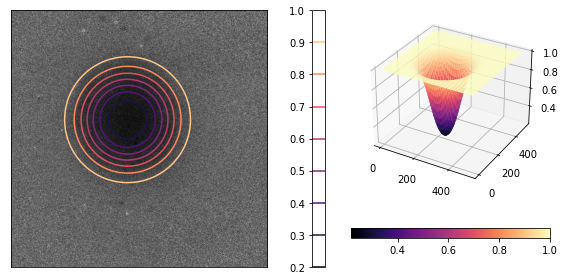

In [182]:
n=50
cmap = 'magma'

X,Y= np.meshgrid(x,y)
Z=np.exp(-df['Depth'][n]*np.exp((-2*((X-df['x0'][n])**2+(Y-df['y0'][n])**2))/(df['Re'][n]**2))) #define optimal fit


fig= plt.figure(figsize=plt.figaspect(0.5))
ax0,ax1= fig.add_subplot(1, 2, 1),fig.add_subplot(1, 2, 2, projection='3d')

ax0.imshow(im_post[n],cmap=plt.cm.gray)
ax0.set_xticks([])
ax0.set_yticks([])
fitted_exp_gauss_contor= ax0.contour(X,Y,Z,cmap=cmap,zlim=(0,1))
cb = fig.colorbar(fitted_exp_gauss_contor,location='left')
fitted_exp_gauss_3d = ax1.plot_surface(X,Y,Z,cmap=cmap,label='Model') 
fig.colorbar(fitted_exp_gauss_3d,location='bottom')

plt.tight_layout()
plt.show()

Make a model for the recovery to get immobile fraction and plot recovery

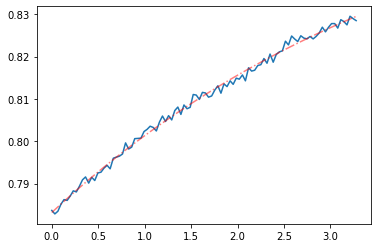

In [27]:
def recovery(x,a,b,c):
    return a*(1-np.exp(-x/b))+c
time=df['Time (s)'].to_numpy(dtype=float)
Int =df['Intensity at Re=sd'].to_numpy(dtype=float)

popt, pcov = curve_fit(recovery, time, Int, maxfev=100, p0=[0.08,4,0.7])
a, b, c = popt

fig, ax = plt.subplots()
ax.plot(time,Int)
ax.plot(time,recovery(time, *popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')
plt.show()

In [29]:
Fi= 1 # Intensity at the start before bleaching~ 1 as normalised
F0= min(df['Intensity at Re=sd'])
Finf=a*(1-np.exp(-999999999999/b))+c #Just use a very large number for Finf
#frac_mobile = (Finf-F0)/(Fi-F0)
frac_mobile = 0.9
print(frac_mobile)

0.9


NOTE- may need to include  a fudge factor here to estimate backwards for the initial bleach intensity

# Find Diff coeff

Perform taylor expansion

In [140]:
def texpansion(t,K,Td):
    total = float(0)
    for n in range(30): #gives the number of terms you want in your expansion
        total = total + (frac_mobile*(-K**n)/((np.math.factorial(n))*(1+n*(1+(2*t/Td)))))  #Add up all the terms in the serise expansion
    return total + (1-frac_mobile)*F0 #return the sum


popt,pcov = curve_fit(texpansion,df['Time (s)'],df['Intensity at Re=sd'],p0=[700,100],maxfev=10000) #optimse for the sum of the t expansion

K,Td = popt            

In [141]:
K,Td

(1.0179694849421115, 48.89274231060565)

In [142]:
pixel_length = (16e-6/150)
w= np.mean((df['Re']))*pixel_length
D=(w**2)/(4*Td)
print(str(D/((10**-6)**2))+'  μm2/s')

0.6757842544250974  μm2/s


In [139]:
df

,x0,y0,Depth,Re,Intensity at Re=sd,Time (s)
0,232.95786,218.336303,1.801532,106.070182,0.783636,0.0
1,233.092048,218.071128,1.809324,106.420801,0.782810,0.03291
2,232.934556,218.569744,1.803335,107.280163,0.783445,0.06582
3,232.925181,218.085115,1.787691,106.259405,0.785105,0.09873
4,233.11403,218.204837,1.777454,105.90348,0.786194,0.13165
...,...,...,...,...,...,...
95,232.69305,216.161851,1.391977,107.247798,0.828297,3.14562
96,232.473162,216.364436,1.398998,107.991755,0.827510,3.17903
97,232.794594,216.301699,1.380806,107.356693,0.829550,3.21181
98,232.425679,216.274203,1.385765,107.744438,0.828994,3.24477


# Radially Average

In [84]:
# Image center
cen_x = spot_df.index[round(len(spot_df.iloc[106]['Col'])/2)]#  find the middle column of the middle row
cen_y = spot_df.index[round((len(spot_df))/2)] #find the middle of the rows
# Get image parameters
a = np.shape(im_post)[1]
b = np.shape(im_post)[2]
# Find radial distances
[X, Y] = np.meshgrid(np.arange(b) - cen_x, np.arange(a) - cen_y)
R = np.sqrt(np.square(X) + np.square(Y))

In [85]:
rad = np.arange(1, np.max(R), 1)
intensity = np.zeros(len(rad))
index = 0
bin_size = 1
for i in rad:
  mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
  values = im_post[1][mask]
  intensity[index] = np.mean(values)
  index += 1

In [86]:
from scipy.optimize import curve_fit

In [97]:
def func(r,A,w):
    return 1-(A*(np.exp((-r**2)/(w**2)))) #Note no beta

popt, pcov = curve_fit(func, rad, intensity, maxfev=10000000)
perr_sd = np.sqrt(np.diag(pcov))

In [98]:
popt, perr_sd

(array([ 0.74170532, 96.27035279]), array([0.01251006, 1.86705186]))

In [99]:
fig, ax = plt.subplots()
ax.plot(rad,intensity)

A, w= popt

ax.plot(rad, func(rad, *popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')

plt.show()

# Hankel Transform

In [20]:
import pyhank

In [71]:
transformer = pyhank.HankelTransform(order=0, max_radius=max(rad), n_points=421)
f=popt[0]*(1-(popt[1]*(np.exp((-(transformer.r**2)/(popt[2]**2))))))

ht = transformer.qdht(rad,f)

In [72]:
fig,ax = plt.subplots()
ax.plot(transformer.kr,ht)

In [31]:
kr, ht=pyhank.one_shot.qdht(rad, intensity, order = 0)
fig, ax = plt.subplots()
ax.plot(kr,ht)

# Try the scipy way

In [ ]:
import scipy

In [170]:
ht,k = scipy.fft.fht(intensity, 421, 0, offset=0.0, bias=0)
fig, ax = plt.subplots()
ax.plot(transformer.kr,ht)

# Try a different way

In [28]:
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

spl = Spline(np.log(rad), np.log(intensity), k=1)
spl_func = lambda x : np.exp(spl(np.log(x)))
fig, ax = plt.subplots()
ax.plot(rad,spl_func(rad))


In [135]:
import hankel
from hankel import HankelTransform 

ht = HankelTransform(
    nu= 0,     # The order of the bessel function
    N = 10000,   # Number of steps in the integration
    h = 100000  # Proxy for "size" of steps in integration
)
    

k = np.logspace(0,3,len(rad),endpoint=True, base=10.0, dtype=None, axis=0)           # Define a spectral grid
Fk = ht.transform(spl_func,(k),ret_err=False) # Return the transform of f at k.
fig, ax = plt.subplots()
ax.plot(1/rad,Fk)
print()

C:\Users\tselb\anaconda3\lib\site-packages\hankel\tools.py:15: RuntimeWarning: overflow encountered in sinh
  return t * np.tanh(np.pi * np.sinh(t) / 2)


# Try for n images

In [161]:
intensity_array=(np.empty((500,len(rad))))
ht_array=(np.empty((500,len(rad))))

In [206]:
# Image center
cen_x = spot_df.index[round(len(spot_df.iloc[106]['Col'])/2)] #  find the middle column of the middle row
cen_y = spot_df.index[round((len(spot_df))/2)] #find the middle of the rows
# Get image parameters
a = np.shape(im_post)[1]
b = np.shape(im_post)[2]
# Find radial distances
[X, Y] = np.meshgrid(np.arange(b) - cen_x, np.arange(a) - cen_y)
R = np.sqrt(np.square(X) + np.square(Y))


def func(r,A,w):
    return (1-(A*(np.exp((-r**2)/(w**2)))))


transformer = pyhank.HankelTransform(order=0, radial_grid=rad)

for j in range(500):
    rad = np.arange(1, np.max(R), 1)
    intensity = np.zeros(len(rad))
    index = 0
    bin_size = 1
    for i in rad:
      mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
      values = im_post[j][mask]
      intensity[index] = np.mean(values)
      index += 1
      
    ht = transformer.qdht(intensity)
    

    intensity_array[j] = intensity
    ht_array[j] = ht

In [210]:
fig, ax = plt.subplots()
n = 300
ax.plot(transformer.kr,(ht_array[n]/ht_array[0]))

In [216]:
fig, ax = plt.subplots()
n = 300
transformer = pyhank.HankelTransform(order=0, radial_grid=rad)
ax.plot(transformer.r,intensity_array[n])

In [212]:
transformer = pyhank.HankelTransform(order=0, max_radius=100, n_points=1024)
f = scipy.special.jv(1, transformer.r) / transformer.r

plt.figure()
plt.plot(transformer.r, f)
plt.xlabel('Radius /m')

Text(0.5, 0, 'Radius /m')

In [213]:
ht = transformer.qdht(f)

plt.figure()
plt.plot(transformer.kr, ht)
plt.xlim([0, 5])
plt.xlabel('Radial wavevector /m$^{-1}$')

Text(0.5, 0, 'Radial wavevector /m$^{-1}$')

In [214]:
f = scipy.special.jv(1, transformer.r) / transformer.r